## Background
1. here we have some DNA sequences, each of arund 50 nucleotides, and labeled with 0 and 1
2. these  are sequences which binds to the protein
3. here 1 means the sequence will bind to the protein and 0 means sequence will not bind to the protein
## Goal 
1. we have to make a model based on training data set which will predict that whether the provided DNA sequence will bind to the protein or not
2. discover the small motif which is binding site for the protein within the sequences which are bound to the protein

## workflow
1. Data Curration
2. Bulding Architecture and train model
3. Evaluate
4. interprete

### Data curration
we will split our data in 3 parts
1. traing dataset
2. validation dataset
3. testing dataset

In [1]:
## importing important dependancies/libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests

In [2]:
## getting our data from the URL
seq_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
sequence = requests.get(seq_url).text.split('\n') ## we will get list of sequences
sequence = list(filter(None,sequence))  ## filtering out the null values in the sequence if any present

## vizualizing first 5 sequences
sequence[:5]

['CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC',
 'GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGCGTCG',
 'GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTAGCCT',
 'GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGCCCTG',
 'GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATATGGT']

In [3]:
## one hot encoding of DNA sequence
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
label_encoder=LabelEncoder()
on_hot_encoder = OneHotEncoder()

In [4]:
sequence[0]

'CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC'

In [5]:
## label encoding
labeled = label_encoder.fit_transform(list(sequence[0]))
labeled

array([1, 1, 2, 0, 2, 2, 2, 1, 3, 0, 3, 2, 2, 3, 3, 3, 2, 2, 0, 0, 2, 3,
       3, 0, 2, 0, 0, 1, 1, 1, 3, 2, 2, 2, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2,
       2, 0, 1, 0, 1, 1], dtype=int64)

In [6]:
labeled.shape

(50,)

In [7]:
labeled=labeled.reshape(-1,1)
labeled = np.array(labeled)
print(labeled.shape)
labeled[:5]

(50, 1)


array([[1],
       [1],
       [2],
       [0],
       [2]], dtype=int64)

In [8]:
one_hot = on_hot_encoder.fit_transform(labeled)

print(one_hot[:5])
print(one_hot.shape)

  (0, 1)	1.0
  (1, 1)	1.0
  (2, 2)	1.0
  (3, 0)	1.0
  (4, 2)	1.0
(50, 4)


In [9]:
one_hot = on_hot_encoder.fit_transform(labeled)
one_hot=one_hot.toarray()
print(one_hot[:5])
one_hot.shape

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


(50, 4)

In [10]:
## one hot encoding for all the sequences
generated_features = []

## accesing each value from the sequence
for seq in sequence:
    ## label encoding
    label_encoded = label_encoder.fit_transform(list(seq))
    ## changing its shape and converting it to the array
    label_encoded = np.array(label_encoded.reshape(-1,1))

    ## one hot encoding
    one_hot_encoded = on_hot_encoder.fit_transform(label_encoded)
    one_hot_encoded = one_hot_encoded.toarray() ## converting metrics into the dense array
    generated_features.append(one_hot_encoded)

## stacking the generated_features array horizontally
generated_features = np.stack(generated_features) ## this will convert list into array
    

In [11]:
generated_features.shape

(2000, 50, 4)

In [12]:
generated_features[0][:10] # one hot encoded dtata for first 10 nucleotides of first sequence

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [13]:
## loading the labels
## labels are in the form of 0 and 1.
#whaere, 1 indicates that protein will bind to the sequence and 0 means it will not bind
label_url = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
labels = requests.get(label_url).text
labels = labels.split('\n')
labels = list(filter(None, labels)) ## removes empty space if there is any

In [14]:
labels[:5]

['0', '0', '0', '1', '1']

In [15]:
## converting the list of labels into array and reshaping the labels for one hot encoding
labels = np.array(labels).reshape(-1,1)

## one hot encoding of the labels
encoded_labels = on_hot_encoder.fit_transform(labels)
## converting encoded_labels to an array
generated_labels = encoded_labels.toarray()

In [16]:
print(generated_labels)
print(generated_labels.shape)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
(2000, 2)


#### splitting data in train and test datasets

In [17]:
from sklearn.model_selection import train_test_split

## splitting data
x_train,x_test,y_train,y_test = train_test_split(generated_features,generated_labels,test_size=0.25,random_state=42)

In [18]:
x_train[1].shape

(50, 4)

### Building architecture and training the model
we will be implementing 1D CNN as it is able to catch patterns

In [19]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix

In [20]:
## building the model
model = keras.Sequential([

    ## adding Convolutional layer
    keras.layers.Conv1D(input_shape=(50,4),filters= 32, kernel_size=12), ## input layer with 32 filters
    keras.layers.MaxPooling1D(4), ## max pooling layer

    ## adding Neural network
    keras.layers.Flatten(),
    keras.layers.Dense(32, activation='relu'), ## 32 layers of neural network
    keras.layers.Dropout(0.5), ## dropout layer with 50% dropout
    keras.layers.Dense(2,activation='softmax') ## outpot layer
])

## compiling the model
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)


c:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,882 (42.51 KB)

 Trainable params: 10,882 (42.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## training the model
training = model.fit(x_train,y_train,epochs=50,verbose=2,validation_split=0.25)
## here verbos means you vant to priint processes while training each epoch 0- don't print anything, 1- print everything,2-print one line at each epoch

In [ ]:
training.history['loss']

In [ ]:
training.history['val_loss']

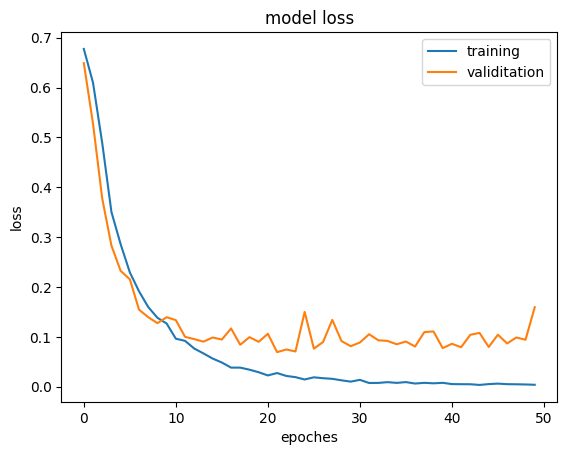

In [25]:
## plotting our loss while training
plt.figure()
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend(['training','validitation'])

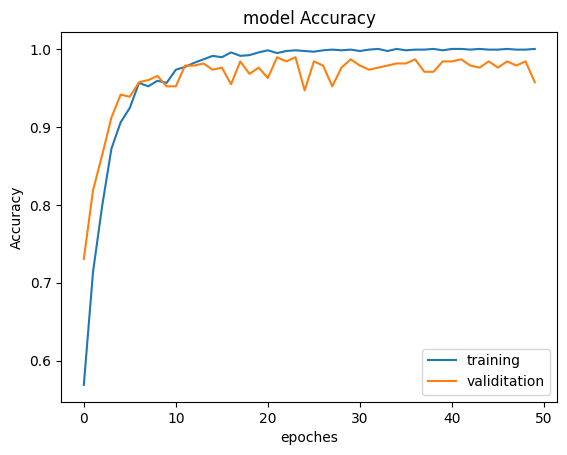

In [26]:
## plotting accuracy while training
plt.figure()
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model Accuracy')
plt.xlabel('epoches')
plt.ylabel('Accuracy')
plt.legend(['training','validitation'])

## Evaluate

we will be evaluating our model on fresh test dataset

In [49]:
model.evaluate(x_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.1143 


[0.09287124872207642, 0.9760000109672546]

In [ ]:
## importing the dependancies
from sklearn.metrics import confusion_matrix

In [38]:
predictions = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [44]:
predictions = [np.argmax(i) for i in predictions]

In [45]:
predictions[:5]

[1, 0, 1, 1, 0]

In [48]:
np.argmax(y_test[:5],axis=1)

array([1, 0, 1, 1, 0], dtype=int64)

In [50]:
## confusion metrics
cm = confusion_matrix((np.argmax(y_test,axis=1)),predictions)
print(cm)

[[247  12]
 [  0 241]]


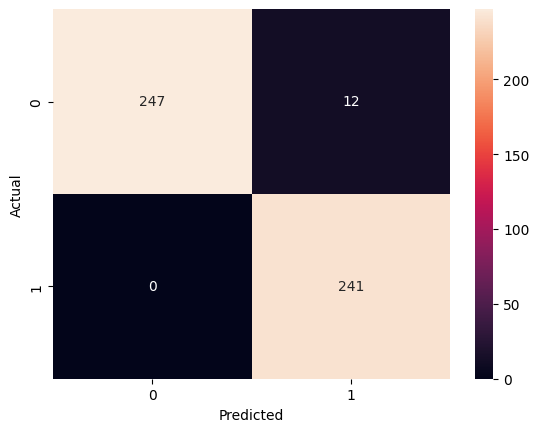

In [54]:
## printing confusion metrics
import seaborn as sns

plt.figure()
sns.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()